# Training with `nn.CTCLoss`

Starting from PyTorch 1.1.0, built-in support for CTC loss is available as `nn.CTCLoss`. Before that, people have to use third-party libraries like `warp-ctc`. We strongly recommend you to use a recent PyTorch version and `nn.CTCLoss` for HW3P2.



## Toy task: English spelling to pronunciation

As a demonstration, we consider the task of predicting the pronunciation (as sequence of phonemes) of an English word given its spelling. The model we use is a bidirectional LSTM.

CTC is actually not the best formulation for this problem, since the letter "X" corresponds to two phonemes "K S", but it works well with our simplified data.

In [1]:
# Words with only E, I, N, S, T.
# Pronunciation is from htttop://www.speech.cs.cmu.edu/cgi-bin/pronounce
data = [
    ('SEE', 'S IY'),
    ('SET', 'S EH T'),
    ('SIT', 'S IH T'),
    ('SITE', 'S AY T'),
    ('SIN', 'S IH N'),
    ('TEEN', 'T IY N'),
    ('TIN', 'T IH N'),
    ('TIE', 'T AY'),
    ('TEST', 'T EH S T'),
    ('NET', 'N EH T'),
    ('NEET', 'N IY T'),
    ('NINE', 'N AY N')
]
letters = 'EINST'
# Starts with ' ' for blank, followed by actual phonemes
phonemes = [' ', 'S', 'T', 'N', 'IY', 'IH', 'EH', 'AY']

Note that, if there are P phonemes for the output, they should be indexed as 1 to P, not 0 to P-1. **Index 0 is reserved for the "blank" symbol by default.**

Accordingly, the output classifier of the model should have P+1 classes, since "blank" is also a class.

In [2]:
import torch
from torch import nn
from torch.nn.utils.rnn import *

X = [torch.LongTensor([letters.find(c) for c in word]) for word, _ in data]
Y = [torch.LongTensor([phonemes.index(p) for p in pron.split()]) for _, pron in data]
X_lens = torch.LongTensor([len(seq) for seq in X])
Y_lens = torch.LongTensor([len(seq) for seq in Y])
X = pad_sequence(X)
# `batch_first=True` is required for use in `nn.CTCLoss`.
Y = pad_sequence(Y, batch_first=True)

print('X', X.size(), X_lens)
print('Y', Y.size(), Y_lens)

X torch.Size([4, 12]) tensor([3, 3, 3, 4, 3, 4, 3, 3, 4, 3, 4, 4])
Y torch.Size([12, 4]) tensor([2, 3, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3])


In [3]:
class Model(nn.Module):
    def __init__(self, in_vocab, out_vocab, embed_size, hidden_size):
        super(Model, self).__init__()
        self.embed = nn.Embedding(in_vocab, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True)
        self.output = nn.Linear(hidden_size * 2, out_vocab)
    
    def forward(self, X, lengths):
        X = self.embed(X)
        packed_X = pack_padded_sequence(X, lengths, enforce_sorted=False)
        packed_out = self.lstm(packed_X)[0]
        out, out_lens = pad_packed_sequence(packed_out)
        # Log softmax after output layer is required since`nn.CTCLoss` expects log probabilities.
        out = self.output(out).log_softmax(2)
        return out, out_lens

## Usage

The official documentation is your best friend: https://pytorch.org/docs/stable/nn.html#ctcloss

`nn.CTCLoss` takes 4 arguments to compute the loss:
* `log_probs`: Prediction of your model at each time step.
  * Shape: (T, N, C), where T is the largest length in the batch, N is batch size, and C is number of classes (remember that it should be number of phonemes plus 1).
  * **Values must be log probabilities.** Neither probabilities nor logits will work. Make sure the output of your network is log probabilities, by adding a `nn.LogSoftmax` after the last linear layer.
* `targets`: The ground truth sequences.
  * Shape: (N, S), where N is batch size, and S is the largest length in the batch. **WARNING!** This dimension order is unconventional in PyTorch. If you use `torch.nn.utils.rnn.pad_sequence` to pad the target sequence,  **you must explicitly set `batch_first=True`**.
  * Values are indices of phonemes. Again, remember that index 0 is reserved for "blank" and should not represent any phoneme.
* `input_lengths`: Lengths of sequences in `log_probs`.
  * Shape: (N,).
  * This is not necessarily the same as lengths of input of the model. If your model uses CNNs or pyramidal RNNs, it changes the length of sequences, and you must correctly compute the lengths of its output to be used here.
* `target_lengths`: Lengths of sequences in `targets`.
  * Shape: (N,).


In [4]:
torch.manual_seed(11785)
model = Model(len(letters), len(phonemes), 4, 4)
criterion = nn.CTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

for epoch in range(50):
    optimizer.zero_grad()
    out, out_lens = model(X, X_lens)
    loss = criterion(out, Y, out_lens, Y_lens)
    print('Epoch', epoch + 1, 'Loss', loss.item())
    loss.backward()
    optimizer.step()

Epoch 1 Loss 2.1582698822021484
Epoch 2 Loss 2.0011541843414307
Epoch 3 Loss 1.8661247491836548
Epoch 4 Loss 1.7121591567993164
Epoch 5 Loss 1.5538407564163208
Epoch 6 Loss 1.4120980501174927
Epoch 7 Loss 1.2837294340133667
Epoch 8 Loss 1.1756290197372437
Epoch 9 Loss 1.070193886756897
Epoch 10 Loss 0.9620561599731445
Epoch 11 Loss 0.8778546452522278
Epoch 12 Loss 0.7992134094238281
Epoch 13 Loss 0.7237516045570374
Epoch 14 Loss 0.6497401595115662
Epoch 15 Loss 0.5727958083152771
Epoch 16 Loss 0.5020315647125244
Epoch 17 Loss 0.43824103474617004
Epoch 18 Loss 0.38061806559562683
Epoch 19 Loss 0.3326881229877472
Epoch 20 Loss 0.295844167470932
Epoch 21 Loss 0.2679532766342163
Epoch 22 Loss 0.2460380643606186
Epoch 23 Loss 0.2276441901922226
Epoch 24 Loss 0.21077193319797516
Epoch 25 Loss 0.19290786981582642
Epoch 26 Loss 0.16913199424743652
Epoch 27 Loss 0.14251136779785156
Epoch 28 Loss 0.13340041041374207
Epoch 29 Loss 0.12046482414007187
Epoch 30 Loss 0.10844077914953232
Epoch 31 Los

# Decoding with `ctcdecode`

During inference, we want to generate the most probable sequence from predicted probabilities. PyTorch doesn't have built-in support for that, so we need another library called `ctcdecode`.

## Installation

If you just follow the steps in https://github.com/parlance/ctcdecode, you may encounter `ModuleNotFoundError: No module named 'wget'`. Simply `pip install wget` solves the problem.

Installing `ctcdecode` with the following steps should be successful. (Change `pip3 install` to either `pip3 install --user` or `sudo -H pip3 install` if you are using the system Python instead of Conda) It takes a few minutes to compile, so be patient.

In [5]:
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget
%cd ctcdecode
!pip install .
%cd ..

Cloning into 'ctcdecode'...
remote: Enumerating objects: 1006, done.
remote: Total 1006 (delta 0), reused 0 (delta 0), pack-reused 1006
Receiving objects: 100% (1006/1006), 728.22 KiB | 1.36 MiB/s, done.
Resolving deltas: 100% (500/500), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/home/amalad/CMU_Acads/TA_11785/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/home/amalad/CMU_Acads/TA_11785/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 56, done.        
remote: Counting objects: 100% (56/56), done.        
remote: Compressing objects: 100% (47/47), done.        
remote: Total 13380 (delta 24), reused 26 (delta 9), pack-reused 13324        
Receiving 

Test whether ctcdecode is working.

Common errors:
* `ImportError: No module named 'ctcdecode._ext'`: Your current working directory is in `ctcdecode`. `cd` into other directories will solve this.
* `undefined symbol: _ZN6caffe26detail37_typeMetaDataInstance_preallocated_32E`: **`torch` MUST be imported before importing `ctcdecode`**, otherwise you will see this.


In [6]:
from ctcdecode import CTCBeamDecoder

decoder = CTCBeamDecoder([' ', 'A'], beam_width=4)
probs = torch.Tensor([[0.2, 0.8], [0.8, 0.2]]).unsqueeze(0)
print(probs.size())
out, _, _, out_lens = decoder.decode(probs, torch.LongTensor([2]))
print(out[0, 0, :out_lens[0, 0]])

torch.Size([1, 2, 2])
tensor([1], dtype=torch.int32)


## Usage

There is no documentation for `ctcdecode`. The only way to understand it is to read the source code. Below, we explain some arguments that are more useful for HW3P2:

`CTCBeamDecoder`:
* `phonemes`: **It doesn't need to be actual phonemes.** The only requirement is being a list of characters whose length is the number of classes (number of phonemes plus 1). 
* `beam_width`: Larger beam width produces better output, but also costs more time and memory.
* `num_processes`: Number of processes for parallel decoding. Setting it to `os.cpu_count()` is recommended as it utilizes all CPU cores.
* `log_probs_input`: Should always be True, since your model output is log probabilities.

`CTCBeamDecoder.decode` arguments:
* `probs`: Prediction from your model as log probabilities (if `log_probs_input=True`).
  * Shape: (N, T, C). where N is batch size, T is the largest length in the batch, and C is number of classes. **WARNING!** This dimension order is unconventional in PyTorch. You likely need to do `out.transpose(0, 1)` on your output.
* `len`: Lengths of sequences in `probs`.
  * Shape: (N,)


`CTCBeamDecoder.decode` return value (tuple of 4):
* First item `output`: Decoded top sequences.
  * Shape: (N, B, T), where B is the beam width. Normally we only need the best sequences, which are indexed 0 in the second (beam width) dimension.
* Second and third can be ignored.
* Last item `out_seq_len`: Length of sequences in `output`. 
  * Shape: (N, B). Lengths of best sequences are indexed 0 in the second (beam width) dimension.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize the probability prediction at each step
def visualize(word, log_probs):
    fig, ax = plt.subplots()
    ax.imshow(log_probs.exp().numpy())
    ax.set_xticks(np.arange(log_probs.size(1)))
    ax.set_yticks(np.arange(log_probs.size(0)))
    ax.set_xticklabels(phonemes)
    ax.set_yticklabels(list(word))
    plt.show()

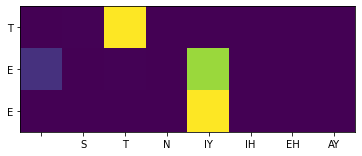

TEE -> T IY


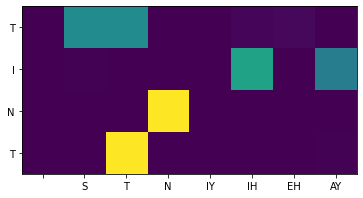

TINT -> S IH N T


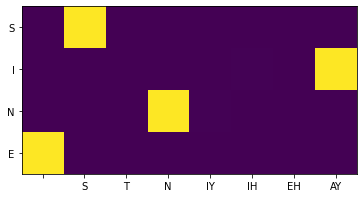

SINE -> S AY N


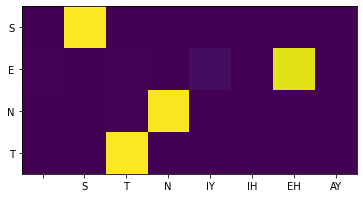

SENT -> S EH N T


In [8]:
test_data = ['TEE', 'TINT', 'SINE', 'SENT']

decoder = CTCBeamDecoder(['$'] * len(phonemes), beam_width=4, log_probs_input=True)

test_X = [torch.LongTensor([letters.find(c) for c in word]) for word in test_data]
test_X_lens = torch.LongTensor([len(seq) for seq in test_X])
test_X = pad_sequence(test_X)

with torch.no_grad():
    model.eval()
    out, out_lens = model(test_X, test_X_lens)

test_Y, _, _, test_Y_lens = decoder.decode(out.transpose(0, 1), out_lens)
for i in range(len(test_data)):
    visualize(test_data[i], out[:len(test_data[i]), i, :])
    # For the i-th sample in the batch, get the best output
    best_seq = test_Y[i, 0, :test_Y_lens[i, 0]]
    best_pron = ' '.join(phonemes[i] for i in best_seq)
    print(test_data[i], '->', best_pron)

## Caveats

* Your program will **crash sliently** if you provide invalid arguments to `CTCBeamDecoder.decode`, like having wrong shapes. It is very difficult to debug such error. During development, we recommend you to **print out all arguments before decoding**, so that you can figure out what goes wrong if it crashes.

In [ ]:
# Don't run this! It will crash your notebook.
decoder = CTCBeamDecoder([' ', 'A'], beam_width=4)
probs = torch.Tensor([[0.1, 0.1, 0.8], [0.8, 0.1, 0.1]]).unsqueeze(0)
out, _, _, out_lens = decoder.decode(probs, torch.LongTensor([2]))